In [7]:
from libaries import *
from data_denoising import *
from data_loading import findFiles,LoadDataSignals
from global_parameters import *
from peak_to_peak_detection import *
from time_synchronization import *

#### Extract relevant files for processing


In [8]:
expected_waveform="sin"
expected_periods="9"
unique_file_list= findFiles(expected_waveform,expected_periods,sample_number=1)
print(unique_file_list)

['/Users/madhviasthana/Documents/Bio-Medical-Signal-Processing/dataset/4th_March_1percent/0000mg/25DegreeTemperature4March-ram-WaterSugar_mid_solution-0mg-sin9-pure_water_solution_1.mat', '/Users/madhviasthana/Documents/Bio-Medical-Signal-Processing/dataset/4th_March_1percent/51000mg/25DegreeTemperature4March-ram-WaterSugar_mid_solution-51000mg-sin9-pure_water_solution_1.mat', '/Users/madhviasthana/Documents/Bio-Medical-Signal-Processing/dataset/4th_March_1percent/187000mg/25DegreeTemperature4March-ram-WaterSugar_mid_solution-187000mg-sin9-pure_water_solution_1.mat', '/Users/madhviasthana/Documents/Bio-Medical-Signal-Processing/dataset/4th_March_1percent/153000mg/25DegreeTemperature4March-ram-WaterSugar_mid_solution-153000mg-sin9-pure_water_solution_1.mat', '/Users/madhviasthana/Documents/Bio-Medical-Signal-Processing/dataset/4th_March_1percent/85000mg/25DegreeTemperature4March-ram-WaterSugar_mid_solution-85000mg-sin9-pure_water_solution_1.mat', '/Users/madhviasthana/Documents/Bio-Medi

In [9]:
raw,Concentration,actual_waveform,periods=LoadDataSignals(unique_file_list[0],time_axis_start=0,time_axis_end=16000)


Detailed Analysis of File: 0000mg (sin9)]


In [10]:
raw.shape

(100, 2, 16000)

In [ ]:
reference_points=find_reference_points_transmit_start(raw,threshold=150000)

In [12]:
"""buffer = 50
for i in range(raw.shape[0]):
    current_ref_point = reference_points[i]
    if  current_ref_point != 0 :
        time_range=np.arange(current_ref_point - buffer,current_ref_point + buffer)
        plt.plot(time_range,raw[i,1,current_ref_point - buffer:current_ref_point + buffer])
        plt.scatter(current_ref_point , raw[i,1,current_ref_point])
        plt.show()
        """

'buffer = 50\nfor i in range(raw.shape[0]):\n    current_ref_point = reference_points[i]\n    if  current_ref_point != 0 :\n        time_range=np.arange(current_ref_point - buffer,current_ref_point + buffer)\n        plt.plot(time_range,raw[i,1,current_ref_point - buffer:current_ref_point + buffer])\n        plt.scatter(current_ref_point , raw[i,1,current_ref_point])\n        plt.show()\n        '

In [13]:
averaged_signal=synchronized_averaging(raw,threshold=500000)

filtered_raw:  (40, 2, 16000)


In [14]:
averaged_signal.shape

(1, 16000)

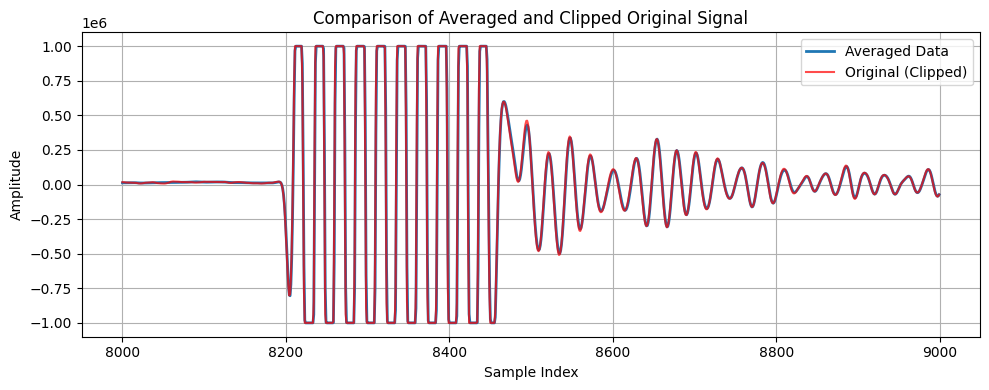

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Clip extreme values in original signal for visibility (e.g., top/bottom 1%)
clip_percentile = 1
original = raw[0, 1, :]
clip_min = np.percentile(original, clip_percentile)
clip_max = np.percentile(original, 100 - clip_percentile)
clipped_original = np.clip(original, clip_min, clip_max)

plt.figure(figsize=(10, 4))
plt.plot(np.arange(8000, 9000), averaged_signal[0][8000:9000], label='Averaged Data', linewidth=2)
plt.plot(np.arange(8000, 9000), clipped_original[8000:9000], label='Original (Clipped)', alpha=0.7, color='red')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Comparison of Averaged and Clipped Original Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
